In [1]:
import json
import pandas as pd

def merge(adata, kdata):
    i2k = {i: k for i, k in enumerate(adata.keys())}
    k2i = {k: i for i, k in i2k.items()}
    
    data = []
    
    for k, arr in adata.items():
        y = k2i[k]
        for d in arr:
            d['y'] = y
            data.append(d)
        
    for k, arr in kdata.items():
        y = k2i[k]
        for d in arr:
            d['y'] = y
            data.append(d)
            
    data = sorted(data, key=lambda d: d['y'])
    
    return i2k, k2i, pd.DataFrame(data)

with open('data-adult.json', 'r') as f:
    adata = json.load(f)
    
with open('data-kid.json', 'r') as f:
    kdata = json.load(f)
    
i2k, k2i, df = merge(adata, kdata)

print(f'df.shape={df.shape}')
print(f'i2k={i2k}')
print(f'k2i={k2i}')

df.shape=(61, 64)
i2k={0: 'rock', 1: 'paper', 2: 'scissor', 3: 'shoot'}
k2i={'rock': 0, 'paper': 1, 'scissor': 2, 'shoot': 3}


In [2]:
df.y.value_counts()

0    18
1    16
2    14
3    13
Name: y, dtype: int64

# Plot poses

In [3]:
def to_points(idx):
    s = df[[c for c in df.columns if c != 'y']].iloc[idx]
    pose = pd.DataFrame(list(zip(*(iter(s),) * 3)), columns=['x', 'y', 'z'])
    return {
        'thumb': pose.iloc[[0, 1, 2, 3, 4],:],
        'index': pose.iloc[[0, 5, 6, 7, 8],:],
        'middle': pose.iloc[[0, 9, 10, 11, 12],:],
        'ring': pose.iloc[[0, 13, 14, 15, 16],:],
        'pinky': pose.iloc[[0, 17, 18, 19, 20],:]
    }

poses = {i2k[c]: to_points(df[df.y == c].index[0]) for c in range(4)}

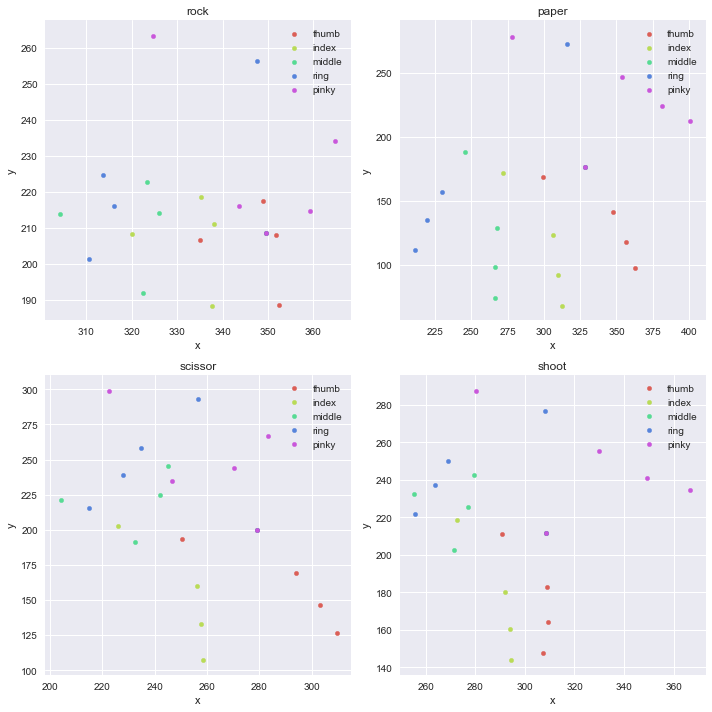

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('seaborn')

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = np.ravel(axes)

colors = sns.color_palette('hls', 5)

for c, ax in zip(poses.keys(), axes):
    pose = poses[c]
    for i, finger in enumerate(['thumb', 'index', 'middle', 'ring', 'pinky']):
        pose[finger].plot.scatter(x='x', y='y', ax=ax, color=colors[i], label=f'{finger}')
    ax.set_title(c)
        
plt.tight_layout()

# K-fold cross-validation

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression

X = df[[c for c in df.columns if c != 'y']]
y = df.y

skf = StratifiedKFold(n_splits=10)

results = []
for train_index, test_index in skf.split(X, y):
    X_train, y_train = X.iloc[train_index], y[train_index]
    X_test, y_test = X.iloc[test_index], y[test_index]
    
    y_test = label_binarize(y_test, classes=[0.0, 1.0, 2.0, 3.0])
    
    clf = LogisticRegression(random_state=37, max_iter=1000).fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    
    roc_macro = roc_auc_score(y_test, y_prob, average='macro')
    roc_micro = roc_auc_score(y_test, y_prob, average='micro')
    roc_weighted = roc_auc_score(y_test, y_prob, average='weighted')
    results.append({
        'macro': roc_macro,
        'micro': roc_micro,
        'weighted': roc_weighted
    })
    
results = pd.DataFrame(results)
results

,macro,micro,weighted
0,1.00000,1.000000,1.000000
1,1.00000,1.000000,1.000000
2,0.82500,0.805556,0.800000
3,0.85625,0.833333,0.841667
4,1.00000,1.000000,1.000000
5,1.00000,1.000000,1.000000
6,1.00000,0.990741,1.000000
7,1.00000,1.000000,1.000000
8,0.96875,0.962963,0.958333
9,1.00000,1.000000,1.000000


In [6]:
results.mean()

macro       0.965000
micro       0.959259
weighted    0.960000
dtype: float64

# Learn model on full data

In [7]:
from sklearn.linear_model import LogisticRegression

X = df[[c for c in df.columns if c != 'y']]
y = df.y

clf = LogisticRegression(random_state=37, max_iter=1000).fit(X, y)

Test the model on a sample.

In [8]:
for i in range(4):
    e = np.exp(clf.intercept_[i] + X.iloc[0].dot(clf.coef_[i]))
    p = e / (1 + e)
    print(f'{i} : {p:.5f}')

0 : 0.99983
1 : 0.29206
2 : 0.00103
3 : 0.28947


In [9]:
models = {}

for clazz, i, c in zip(['rock', 'paper', 'scissor', 'shoot'], clf.intercept_, clf.coef_):
    models[clazz] = {
        'intercept': float(i),
        'coefs': [float(w) for w in c]
    }

In [10]:
import json

with open('models.json', 'w') as f:
    json.dump(models, f, indent=1)